# Demo parameter sweeps of channel measurements
This demonstrates the construction of larger datasets built by looping across measurements of different channels.

In [1]:
from edge_analyzer import channel_waveform
from edge_analyzer.io import simulated_awgn
import xarray as xr

sample_rate_Hz = 15.36e6
analysis_bandwidth_Hz = 10e6

analysis_spec = {
    'power_time_series': {
        'detector_period': 10e-3,
        'detectors': ('rms', 'peak')
    },
    'cyclic_channel_power': {
        'cyclic_period': 10e-3,
        'detector_period': 1e-3 / 15 / 4,
        'detectors': ('rms', 'peak'),
        'cyclic_statistics': ('min', 'mean', 'max'),
    },
    'persistence_spectrum': {
        'window': 'flattop',
        'resolution': 15e3,
        'quantiles': [0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 0.999, 1],
    },
    'amplitude_probability_distribution': {
        'power_low': -40,
        'power_high': 15,
        'power_count': 221,  # 0.25 dB resolution
    },
    'iq_waveform': {
        'start_time_sec': 0,
        'stop_time_sec': 100e-3
    }
}

filter_spec = {
    'ola': {
        'fft_size': 1024,
        'window': 'hamming',  # 'hamming', 'blackman', or 'blackmanharris'
    },
}

acquisition_spec = {
    'duration': 0.2,
    'sample_rate': sample_rate_Hz
}

### Single acquisition

In [2]:
iq = simulated_awgn(
    **acquisition_spec, power=sample_rate_Hz / analysis_bandwidth_Hz
)

channel_waveform.from_spec(
    iq,
    sample_rate_Hz,
    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
    filter_spec=filter_spec,
    analysis_spec=analysis_spec,
)

<xarray.Dataset> Size: 25MB
Dimensions:                             (persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         power_detector: 2,
                                         cyclic_statistic: 3, cyclic_lag: 600,
                                         time_elapsed: 20, channel_power: 221,
                                         iq_sample: 1536000,
                                         temperature_sensor: 0,
                                         compute_status_category: 3)
Coordinates:
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * time_elapsed                        (time_elapsed) float64 160B 0.0 ... 0.19
  * channel_power                       (channel_power) float32 884B -40.0 .....
  * iq_sample                           (iq_sample) int64 12MB 0 1 ... 1535999
  * temperature_sensor                  (temperature_sensor) float64 0B 
  * compute_status_category             (compute_status_category) <U21 252B '...
Data variables:
    persistence_spectrum                (persistence_statistic, baseband_frequency) float32 24kB ...
    cyclic_channel_power                (power_detector, cyclic_statistic, cyclic_lag) float32 14kB ...
    power_time_series                   (power_detector, time_elapsed) float32 160B ...
    amplitude_probability_distribution  (channel_power) float32 884B 0.9999 ....
    iq_waveform                         (iq_sample) complex64 12MB (-0.064996...
    temperature                         (temperature_sensor) float64 0B 
    compute_status                      (compute_status_category) float64 24B ...
Attributes:
    sample_rate_Hz:         15360000.0
    analysis_bandwidth_Hz:  10000000.0
    filter:                 {'ola': {'fft_size': 1024, 'window': 'hamming'}}
    metadata_version:       0.0.0
    git_remote:             https://github.com/usnistgov/spectrum-sensor-edge...
    git_commit:             057a83678e2341ab3eb6a230fbb1449803ceb34d
    sensor_uuid:            0xa6275c05e9dd

## RF parameter sweep
### Single parameter

In [3]:
data = []

for fc in [3705e6, 3715e6, 3725e6]:
    iq = simulated_awgn(
        **acquisition_spec, power=sample_rate_Hz / analysis_bandwidth_Hz
    )

    ret = channel_waveform.from_spec(
        iq,
        sample_rate_Hz,
        analysis_bandwidth_Hz=analysis_bandwidth_Hz,
        filter_spec=filter_spec,
        analysis_spec=analysis_spec,
    )

    data.append(ret.assign_coords({'center_frequency': [fc]}))

data = xr.combine_by_coords(data)
data

<xarray.Dataset> Size: 49MB
Dimensions:                             (persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         center_frequency: 3,
                                         power_detector: 2,
                                         cyclic_statistic: 3, cyclic_lag: 600,
                                         time_elapsed: 20, channel_power: 221,
                                         iq_sample: 1536000,
                                         temperature_sensor: 0,
                                         compute_status_category: 3)
Coordinates:
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * time_elapsed                        (time_elapsed) float64 160B 0.0 ... 0.19
  * channel_power                       (channel_power) float32 884B -40.0 .....
  * iq_sample                           (iq_sample) int64 12MB 0 1 ... 1535999
  * temperature_sensor                  (temperature_sensor) float64 0B 
  * compute_status_category             (compute_status_category) <U21 252B '...
  * center_frequency                    (center_frequency) float64 24B 3.705e...
Data variables:
    persistence_spectrum                (center_frequency, persistence_statistic, baseband_frequency) float32 72kB ...
    cyclic_channel_power                (center_frequency, power_detector, cyclic_statistic, cyclic_lag) float32 43kB ...
    power_time_series                   (center_frequency, power_detector, time_elapsed) float32 480B ...
    amplitude_probability_distribution  (center_frequency, channel_power) float32 3kB ...
    iq_waveform                         (center_frequency, iq_sample) complex64 37MB ...
    temperature                         (center_frequency, temperature_sensor) float64 0B ...
    compute_status                      (center_frequency, compute_status_category) float64 72B ...
Attributes:
    sample_rate_Hz:         15360000.0
    analysis_bandwidth_Hz:  10000000.0
    filter:                 {'ola': {'fft_size': 1024, 'window': 'hamming'}}
    metadata_version:       0.0.0
    git_remote:             https://github.com/usnistgov/spectrum-sensor-edge...
    git_commit:             057a83678e2341ab3eb6a230fbb1449803ceb34d
    sensor_uuid:            0xa6275c05e9dd

In [4]:
data = []

for atten in [0.0, 10.0]:
    for fc in [3705e6, 3715e6, 3725e6]:
        iq = simulated_awgn(
            **acquisition_spec, power=sample_rate_Hz / analysis_bandwidth_Hz
        )

        ret = (
            channel_waveform
            .from_spec(
                    iq,
                    sample_rate_Hz,
                    analysis_bandwidth_Hz=analysis_bandwidth_Hz,
                    filter_spec=filter_spec,
                    analysis_spec=analysis_spec,
                )
            .assign_coords(
                {'center_frequency': [fc], 'attenuation': [atten]}
            )
        )

        data.append(ret)

dataset = xr.combine_by_coords(data)
dataset.center_frequency.attrs = {'label': 'RF center frequency', 'units': 'Hz'}
dataset.attenuation.attrs = {'label': 'External attenuation setting', 'units': 'dB'}

In [5]:
(
    dataset
    .chunk({'iq_sample': round(dataset.attrs['sample_rate_Hz']*10e-3)})
    .to_zarr('dataset.zarr', mode='w')
)

dataset

<xarray.Dataset> Size: 86MB
Dimensions:                             (persistence_statistic: 9,
                                         baseband_frequency: 667,
                                         attenuation: 2, center_frequency: 3,
                                         power_detector: 2,
                                         cyclic_statistic: 3, cyclic_lag: 600,
                                         time_elapsed: 20, channel_power: 221,
                                         iq_sample: 1536000,
                                         temperature_sensor: 0,
                                         compute_status_category: 3)
Coordinates:
  * persistence_statistic               (persistence_statistic) <U5 180B '0.1...
  * baseband_frequency                  (baseband_frequency) float64 5kB -4.9...
  * power_detector                      (power_detector) <U4 32B 'rms' 'peak'
  * cyclic_statistic                    (cyclic_statistic) <U4 48B 'min' ... ...
  * cyclic_lag                          (cyclic_lag) float64 5kB 0.0 ... 0.00...
  * time_elapsed                        (time_elapsed) float64 160B 0.0 ... 0.19
  * channel_power                       (channel_power) float32 884B -40.0 .....
  * iq_sample                           (iq_sample) int64 12MB 0 1 ... 1535999
  * temperature_sensor                  (temperature_sensor) float64 0B 
  * compute_status_category             (compute_status_category) <U21 252B '...
  * center_frequency                    (center_frequency) float64 24B 3.705e...
  * attenuation                         (attenuation) float64 16B 0.0 10.0
Data variables:
    persistence_spectrum                (attenuation, center_frequency, persistence_statistic, baseband_frequency) float32 144kB ...
    cyclic_channel_power                (attenuation, center_frequency, power_detector, cyclic_statistic, cyclic_lag) float32 86kB ...
    power_time_series                   (attenuation, center_frequency, power_detector, time_elapsed) float32 960B ...
    amplitude_probability_distribution  (attenuation, center_frequency, channel_power) float32 5kB ...
    iq_waveform                         (attenuation, center_frequency, iq_sample) complex64 74MB ...
    temperature                         (attenuation, center_frequency, temperature_sensor) float64 0B ...
    compute_status                      (attenuation, center_frequency, compute_status_category) float64 144B ...
Attributes:
    sample_rate_Hz:         15360000.0
    analysis_bandwidth_Hz:  10000000.0
    filter:                 {'ola': {'fft_size': 1024, 'window': 'hamming'}}
    metadata_version:       0.0.0
    git_remote:             https://github.com/usnistgov/spectrum-sensor-edge...
    git_commit:             057a83678e2341ab3eb6a230fbb1449803ceb34d
    sensor_uuid:            0xa6275c05e9dd

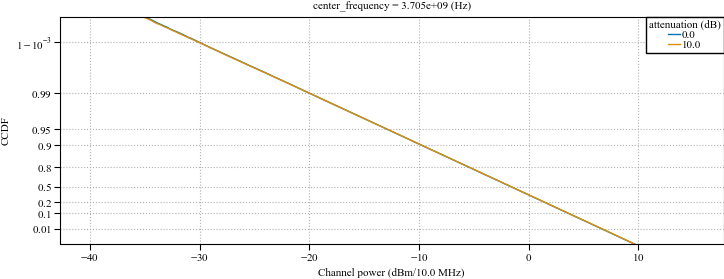

In [6]:
import iqwaveform
from edge_analyzer import figures
import matplotlib.pyplot as plt
plt.style.use('iqwaveform.ieee_double_column')

fig, ax = plt.subplots()
apd = dataset.amplitude_probability_distribution.sel(center_frequency=3705e6)
apd.plot.line(x='channel_power', ax=ax)
ax.set_yscale('gamma-qq', k=1, db_ordinal=True)
figures.label_axis(ax.xaxis, apd, 'channel_power', tick_units=False)
figures.label_axis(ax.yaxis, apd)

In [7]:
import zarr
from pathlib import Path
import numcodecs
import numcodecs.zfpy
import numpy as np

def directory_size(path):
    path = Path(path)
    if path.is_file():
        return path.stat().st_size
    
    children = Path(path).glob('**/*')
    return sum([p.stat().st_size for p in children if p.is_file()])

# assume we will want to read 10 ms at a time for performance reasons
path = 'xarray-sweep.zarr'

# orient the data under the assumption that we want to load 1 frame at a time
chunks = {'iq_sample': round(dataset.attrs['sample_rate_Hz']*10e-3)}

%timeit -n1 -r1 dataset.sel(attenuation=0,center_frequency=3705e6).chunk(chunks).to_zarr(path, mode='w')

print(f'data size: {directory_size(path)/1e6:0.1f} MB')

56.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
data size: 11.4 MB
